In [55]:
%matplotlib inline
import matplotlib.pyplot as plt 

In [56]:
import numpy as np 
import pandas 
from itertools import product, combinations
from primer3 import calcHomodimer, calcHeterodimer, calcTm

In [57]:
# generate all possible 8-mer DNA sequences without homopolymers
# we want to avoid homopolyers in our barcodes 

In [58]:
alphabet = 'ATCG'

In [59]:
def has_homopolymers( sequence ):
    for i in range( len( sequence ) - 1 ):
        if sequence[ i ] == sequence[ i + 1 ]:
            return True 
    return False

In [60]:
barcode_length = 8 
barcodes = []
for combo in product( alphabet, repeat=barcode_length ):
    if not has_homopolymers( combo ):
        barcodes.append( ''.join( combo ) )

In [61]:
# so this works for generic Sanger primer, 
# we make these variables 

In [62]:
forward_sanger_primer = 'TAATACGACTCACTATAGGG' #t7 fwd
reverse_sanger_primer = 'GCTAGTTATTGCTCAGCGG' #t7 rev

In [63]:
# describe the input primers 

forward_seq_primer_tm = calcTm( forward_sanger_primer ) 
reverse_seq_primer_tm = calcTm( reverse_sanger_primer ) 

print( '{0:2.2f}, {1:2.2f}'.format( forward_seq_primer_tm, reverse_seq_primer_tm ) )

wt_tm = { 'forward': forward_seq_primer_tm, 'reverse': reverse_seq_primer_tm } 

44.59, 50.61


In [64]:
fwd_primers = [ b + forward_sanger_primer for b in barcodes ]
rev_primers = [ b + reverse_sanger_primer for b in barcodes ]

In [65]:
# let's make a DataFrame out of this right now 
data = [ ( fwd_primer, 'forward' ) for fwd_primer in fwd_primers ] + [ ( rev_primer, 'reverse' ) for rev_primer in rev_primers ] 
df = pandas.DataFrame( data, columns=['sequence', 'direction'] )
df.sample( 2 ) 

,sequence,direction
5433,CTCTATGATAATACGACTCACTATAGGG,forward
17139,GCTCTGTAGCTAGTTATTGCTCAGCGG,reverse


In [66]:
# calc Tm for each 

df[ 'primary_tm' ] = list( map( lambda x: wt_tm[x], df.direction ) ) 
df[ 'secondary_tm' ] = list( map( calcTm, df.sequence ) ) 
df.sample( 2 ) 

,sequence,direction,primary_tm,secondary_tm
7360,GTATGTGTTAATACGACTCACTATAGGG,forward,44.591869,53.106073
5975,CGACGAGCTAATACGACTCACTATAGGG,forward,44.591869,57.987610


In [67]:
# so, now let's filter this list down 

# first, let's exclude the homopolymers we accidentally introduced 
# that arise because the barcode is next to the sequencing primer 
# remove these homopolymers 

# second, calculate the secondary Tm (Tm of entire barcode+primer pair) 
# throw out if the secondary Tm is too far from the original Tm (5 ˚C cutoff)
# is there a way to set up the PCR that will work for a wide variety of Tm? 

# third, of all of the primers that pass, form a pool and calculate the propensity 
# of hetreodimeriztion pairwise until they are pairwise independent

# only then think about Hamming distances
# I'm guessing 100 

In [68]:
def check_introduced_homopolymers( sequence, barcode_length ):
    # barcode is on the 5' end of the sequence
    if sequence[ barcode_length ] == sequence[ barcode_length - 1 ]:
        return True 
    else:
        return False 
    
df[ 'introduced_homopolymers' ] = df.sequence.map( lambda x: check_introduced_homopolymers( x, barcode_length ) )
df.sample( 2 ) 

,sequence,direction,primary_tm,secondary_tm,introduced_homopolymers
2951,TCATCAGCTAATACGACTCACTATAGGG,forward,44.591869,55.428982,False
4566,CATGTACATAATACGACTCACTATAGGG,forward,44.591869,52.938225,False


In [69]:
df[ 'delta_tm' ] = abs( df[ 'primary_tm' ].subtract( df['secondary_tm' ] ) )
df.head()

,sequence,direction,primary_tm,secondary_tm,introduced_homopolymers,delta_tm
0,ATATATATTAATACGACTCACTATAGGG,forward,44.591869,48.022858,True,3.430989
1,ATATATACTAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
2,ATATATAGTAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
3,ATATATCATAATACGACTCACTATAGGG,forward,44.591869,49.802981,False,5.211112
4,ATATATCTTAATACGACTCACTATAGGG,forward,44.591869,49.753013,True,5.161144


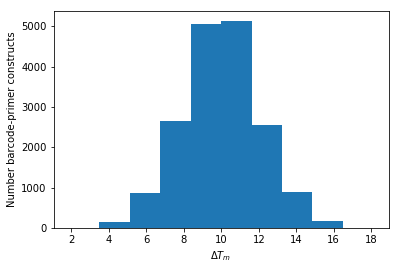

In [70]:
plt.hist( df['delta_tm'] )
plt.xlabel( '$\Delta T_m$' ) 
plt.ylabel( 'Number barcode-primer constructs' ) 

In [85]:
delta_tm_cutoff = 6 # ˚C 

chosen = df[
    ( df.introduced_homopolymers == False ) & 
    ( df.delta_tm < delta_tm_cutoff )
] 

chosen.shape

(321, 6)

In [86]:
chosen

,sequence,direction,primary_tm,secondary_tm,introduced_homopolymers,delta_tm
1,ATATATACTAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
2,ATATATAGTAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
3,ATATATCATAATACGACTCACTATAGGG,forward,44.591869,49.802981,False,5.211112
6,ATATATGATAATACGACTCACTATAGGG,forward,44.591869,49.802981,False,5.211112
12,ATATACTATAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
21,ATATAGTATAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
27,ATATCATATAATACGACTCACTATAGGG,forward,44.591869,49.802981,False,5.211112
54,ATATGATATAATACGACTCACTATAGGG,forward,44.591869,49.802981,False,5.211112
108,ATACTATATAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798
189,ATAGTATATAATACGACTCACTATAGGG,forward,44.591869,49.328667,False,4.736798


In [89]:
from functools import reduce 
from scipy.spatial.distance import hamming

In [100]:
def sum_of_pairwise_hamming( sequences ): 
    # accepts iterable of sequences 
    # outputs scalar sum of hamming distances pairwise 
    return reduce( hamming, combinations( sequences ) ) 

fwd_only = list( df[(df['direction']=='forward')].sequence ) 

sum_so_far = 0
pool = list( np.random.choice( fwd_only ) ) 
for seq in fwd_only:
    pool.append( np.random.choice( fwd_only ) ) 
    print( sum_of_pairwise_hamming( pool ) ) 
    

TypeError: Required argument 'r' (pos 2) not found

In [104]:
hamming?

In [107]:
pool = [ 'AAA', 'AAT', 'ATT', 'TTT', 'CCC' ] 
for i, j in combinations( pool, 2 ):
    print( i, j, hamming( i, j ) ) 

AAA AAT 1.0
AAA ATT 1.0
AAA TTT 1.0
AAA CCC 1.0
AAT ATT 1.0
AAT TTT 1.0
AAT CCC 1.0
ATT TTT 1.0
ATT CCC 1.0
TTT CCC 1.0


In [113]:
reduce?

In [125]:
fwd_only = list( chosen[(chosen['direction']=='forward')].sequence ) 

pool = [ np.random.choice( fwd_only ) ] 
total_ham = 0
for seq in fwd_only:
    choice = np.random.choice( fwd_only )
    candidates = pool + [choice]
    sum_candidates = sum( [ hamming(u, v) for u, v in combinations( candidates, 2 ) ] ) 
    total_ham = sum_candidates
    if ( sum_candidates / len( candidates ) ) <= ( total_ham / len( pool ) ):
        pool.append( choice ) 

In [126]:
len( pool ) 

64

In [127]:
pool

['CTATATAGTAATACGACTCACTATAGGG',
 'GCTATATATAATACGACTCACTATAGGG',
 'ATATATGATAATACGACTCACTATAGGG',
 'CATATAGATAATACGACTCACTATAGGG',
 'CATATAGATAATACGACTCACTATAGGG',
 'TATCTATATAATACGACTCACTATAGGG',
 'GATATATATAATACGACTCACTATAGGG',
 'CTATAGTATAATACGACTCACTATAGGG',
 'ATGATATATAATACGACTCACTATAGGG',
 'GATATATATAATACGACTCACTATAGGG',
 'CTATCATATAATACGACTCACTATAGGG',
 'CATAGATATAATACGACTCACTATAGGG',
 'TATACATATAATACGACTCACTATAGGG',
 'GATATATCTAATACGACTCACTATAGGG',
 'CTATATACTAATACGACTCACTATAGGG',
 'GATATATCTAATACGACTCACTATAGGG',
 'GATATAGATAATACGACTCACTATAGGG',
 'CTATACTATAATACGACTCACTATAGGG',
 'ATATACTATAATACGACTCACTATAGGG',
 'CGTATATATAATACGACTCACTATAGGG',
 'GTACTATATAATACGACTCACTATAGGG',
 'CTCATATATAATACGACTCACTATAGGG',
 'CTATATCATAATACGACTCACTATAGGG',
 'CATATCTATAATACGACTCACTATAGGG',
 'CTATGATATAATACGACTCACTATAGGG',
 'CTAGTATATAATACGACTCACTATAGGG',
 'CTATATGATAATACGACTCACTATAGGG',
 'CATCTATATAATACGACTCACTATAGGG',
 'CATAGATATAATACGACTCACTATAGGG',
 'GTATACTATAATACGACTCACTATAGGG',
 'TATATATG